<a href="https://colab.research.google.com/github/svondracek0/Data-Science-Practicum/blob/main/Vondracek_Housing_Prices_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Prices Task
*Stepan Vondracek, 11/12/2021*

## Introduction

In this task, I was supposed to conduct an exploratory data analysis and subsequent linear regression over the *housing dataset* I have been given.    
I won't deny that I have found out it is an *Ames Housing Data set* originally from Kaggle where it was used in a competition.  
When approaching the problem, I took a look at other people's approach at some points. However, the reasoning I use as well as a majority of the code is my own.   
I did not use any methods 'because people on the Towards Data Science did it' and I dare to claim that I can justify my every single step I make in this analysis.  
The analysis is divided into three main sections:

1.   Data Transformation
2.   EDA
3.   Regression

In the Regression section, I use only the OLS method and try to improve the model performance using the target variable's logarithmization as well as the 







In [240]:
# Import al the needed libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
!pip install probscale
import probscale
plt.style.use('ggplot') 

%matplotlib inline


In [241]:
import statsmodels.api as sm
from sklearn import metrics, linear_model
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import shapiro

In [242]:
% cd '/content/drive/MyDrive/'
#% cd "/content/drive/MyDrive/intern_data" #mount the Google Drive
#% mkdir "intern_data" #create a directory 

/content/drive/MyDrive


In [243]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive("Intern_task_data.7z").extractall("./intern_data") #hereby I extract the .7z file in my Drive


In [244]:
% cd ./intern_data/
% ls

/content/drive/MyDrive/intern_data
data_1.csv  data_2.csv  data_description.txt


## 1 Prior Reasoning
There are various approaches towards predicting house prices. One particularly common is the so called *hedonic pricing*. From the standard economic theory, the price of a house should reflect the actual utility it can generate to its potential owner.   
It is built on the basis of revealed preferences theorems, i.e. the assumption that the best way to predict a house's value is to compare it to other houses which have been already sold.  
Further, I won't elaborate on the theory. For our purpose it is sufficient to state that such method requires an identification of regressors which influence the price the most and use only these in our regression model.




In [245]:
!pwd

/content/drive/MyDrive/intern_data


## 2 Preparing the Data
I have been given two .csv datasets and a .txt file which contains an information on variables which are herein contained.

In [246]:
# I commented the bloc because ecause the length of the text file is disturbing
# desc_file = "data_description.txt"
# file_desc = open(desc_file, "r")
# print(file_desc.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [247]:
data_1 = pd.read_csv("data_1.csv")
data_2 = pd.read_csv("data_2.csv")

data_1.info() #as we'll further see, printing the summary just for the dataset 1 is sufficient

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149 entries, 0 to 1148
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1149 non-null   int64  
 1   MSSubClass     1149 non-null   int64  
 2   MSZoning       1149 non-null   object 
 3   LotFrontage    947 non-null    float64
 4   LotArea        1149 non-null   int64  
 5   Street         1149 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1149 non-null   object 
 8   LandContour    1149 non-null   object 
 9   Utilities      1149 non-null   object 
 10  LotConfig      1149 non-null   object 
 11  LandSlope      1149 non-null   object 
 12  Neighborhood   1149 non-null   object 
 13  Condition1     1149 non-null   object 
 14  Condition2     1149 non-null   object 
 15  BldgType       1149 non-null   object 
 16  HouseStyle     1149 non-null   object 
 17  OverallQual    1149 non-null   int64  
 18  OverallC

In [248]:
for var in data_1:
  if var not in data_2:
    print(var)
# these 3 variables are not present in the second data set, data_1 contains all of data_2 variables

Alley
FireplaceQu
PoolQC


## 3 Exploratory Data Analysis

The two datasets seem to be independent in terms of observations. The first dataset contains more variables as well as more observations. It is further convenient to combine the two datasets. The former data_2 rows will naturally contain NAs for the three variables. Talking about the NAs, it is usefull to find out how are the NAs handled in the dataset. I can do it by searching the .txt file - NAs are apparently marked as 'NA'.

In [249]:
dfs = [data_1, data_2]
data_merged = pd.concat(dfs, join="outer") #hereby I merge the two datasets, the outer join ensures that all variables will be kept
len(pd.unique(data_merged["Id"])) == len(data_merged) #the length of unique values equals the n of rows

True

The following function prints a table of missing or zero vaues in our data set. From naively assessing these variables, I conclude that variables, which are the most affected by NAs, are most likely the ones of a little significance. Because of a high NAs share in certain variables, I further drop these from our data set.

In [250]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

na_table = missing_zero_values_table(data_merged)
na_table

Your selected dataframe has 81 columns and 1460 Rows.
There are 19 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
PoolQC,0,1458,99.9,1458,99.9,object
MiscFeature,0,1406,96.3,1406,96.3,object
Alley,0,1390,95.2,1390,95.2,object
Fence,0,1179,80.8,1179,80.8,object
FireplaceQu,0,856,58.6,856,58.6,object
LotFrontage,0,259,17.7,259,17.7,float64
GarageType,0,81,5.5,81,5.5,object
GarageYrBlt,0,81,5.5,81,5.5,float64
GarageFinish,0,81,5.5,81,5.5,object
GarageQual,0,81,5.5,81,5.5,object


In [251]:
drop_na_affected = na_table[na_table['% of Total Values'] > 50].index.values #hereby I select the most NAs-affected variables from our dataset
data_merged = data_merged.drop(drop_na_affected, 1) #Dropping the selected ones

It is also useful to check whether our dataset contains duplicities. Apparantly there are no dupicities in 'Id' variable. On the other hand, the index does not contain unique values, hence I will reindex using the 'Id' column (duplicit indexing would cause troouble in the later analysis, e.g. in pairplots).

In [252]:
data_merged.index = data_merged['Id']
data_merged = data_merged.drop('Id', 1)
data_merged.tail

<bound method NDFrame.tail of       MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition SalePrice
Id                                      ...                                  
1             60       RL         65.0  ...        WD        Normal    208500
2             20       RL         80.0  ...        WD        Normal    181500
3             60       RL         68.0  ...        WD        Normal    223500
4             70       RL         60.0  ...        WD       Abnorml    140000
5             60       RL         84.0  ...        WD        Normal    250000
...          ...      ...          ...  ...       ...           ...       ...
1456          60       RL         62.0  ...        WD        Normal    175000
1457          20       RL         85.0  ...        WD        Normal    210000
1458          70       RL         66.0  ...        WD        Normal    266500
1459          20       RL         68.0  ...        WD        Normal    142125
1460          20       RL         

To get a general idea of the origin of our data, I find it convenient to focus on the year when particular house has been built. As we can see, the majority of houses have been built quite recently. However, more relevant for our case would be the variable 'age' - older houses have been rebuilt and such makeover certainly affects the price.

Text(0.5, 1.0, 'Built in:')

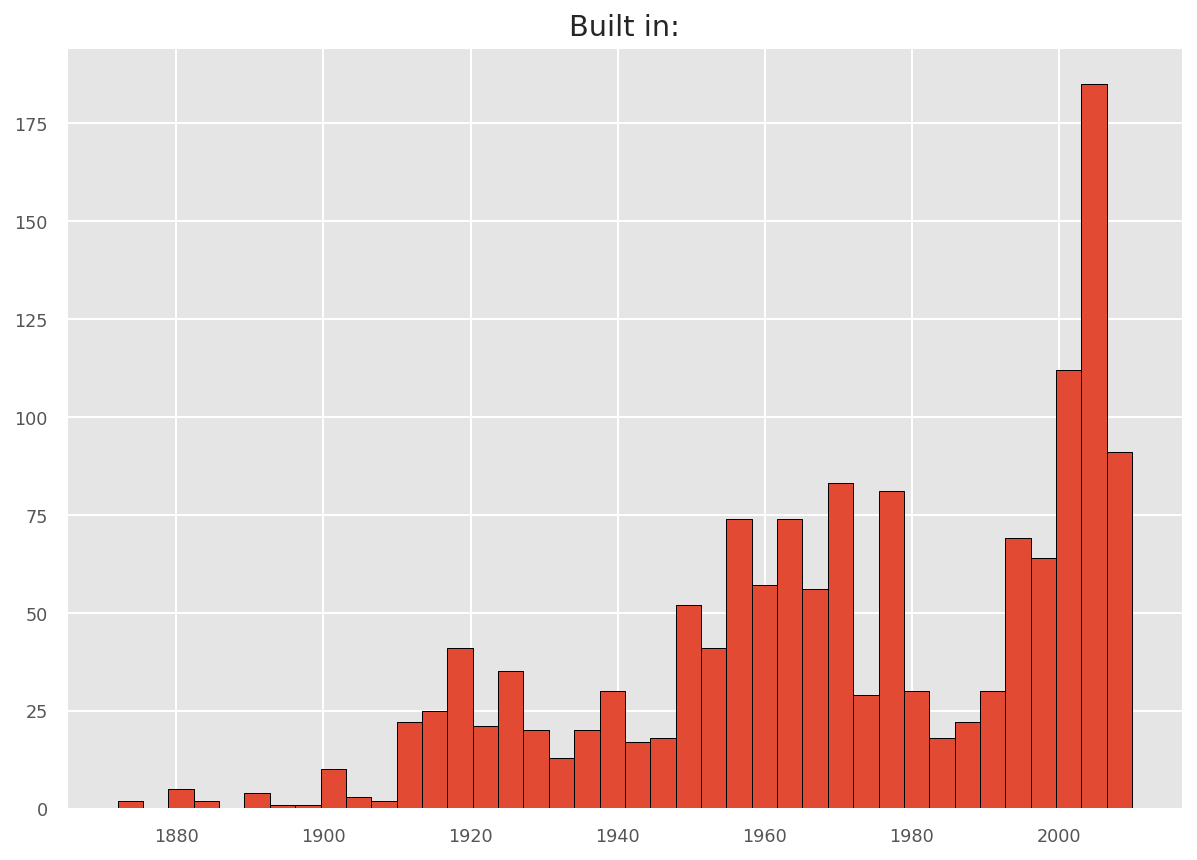

In [253]:
built_hist = (data_merged['YearBuilt']).hist(bins=40, ec="black", figsize=(10,7))
built_hist.set_title("Built in:")

The results in case of makeovers are quite odd. As we can see, there were no makeovers prior to the 1950 which is hardly imaginable. To 'standardize' our data, I create another variable 'age' which captures the actual age of a house in the moment of purchase.

Text(0.5, 1.0, 'Last Makeover in:')

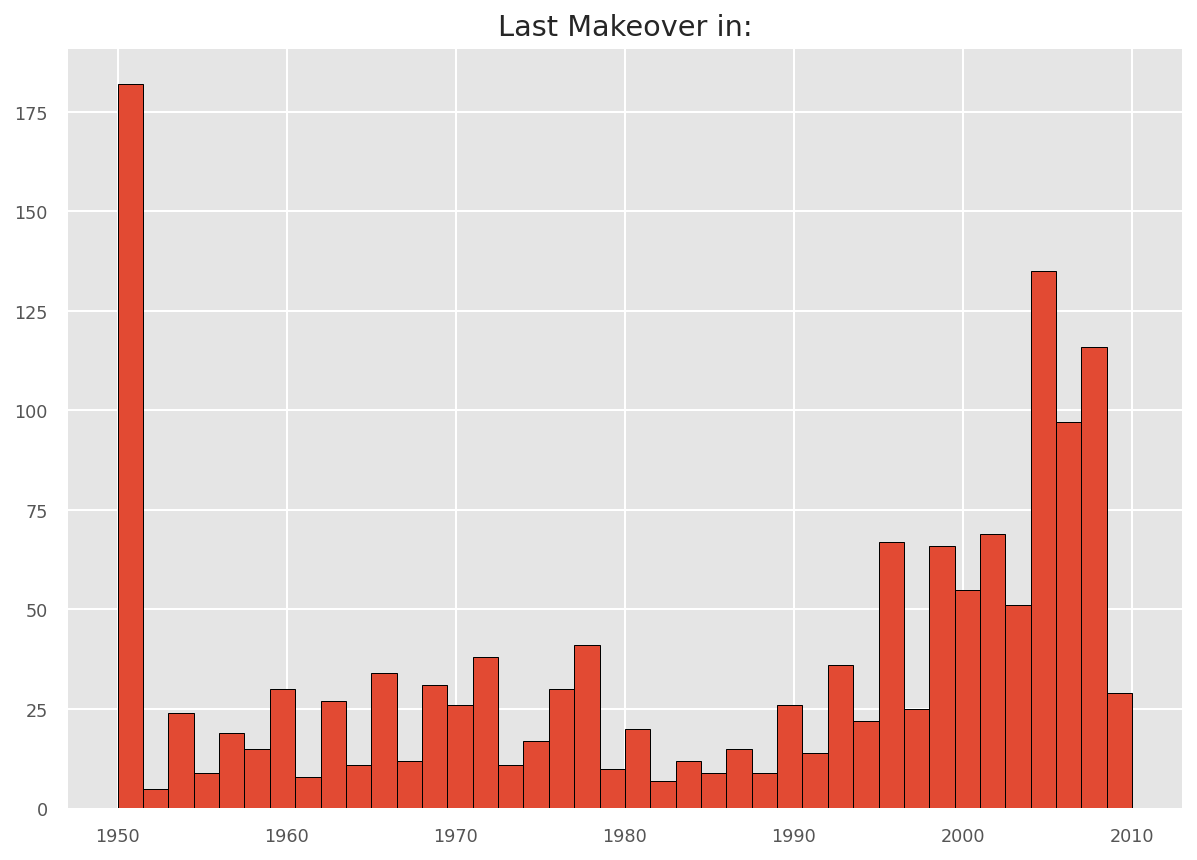

In [254]:
recent_makeover_hist = (data_merged['YearRemodAdd']).hist(bins=40, ec="black", figsize=(10,7))
recent_makeover_hist.set_title("Last Makeover in:")

Because of sufficient number of observations, I suggest excluding the houses with 'YearRemodAdd'==1950 from our analysis. The variable 'Age' will almost surely play significant role in the regression and such values would bias our results.    

In [255]:
data_merged = data_merged[data_merged['YearRemodAdd'] > 1950]
data_merged['Age'] = data_merged['YrSold'] - data_merged['YearRemodAdd']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Age in the moment of purchase:')

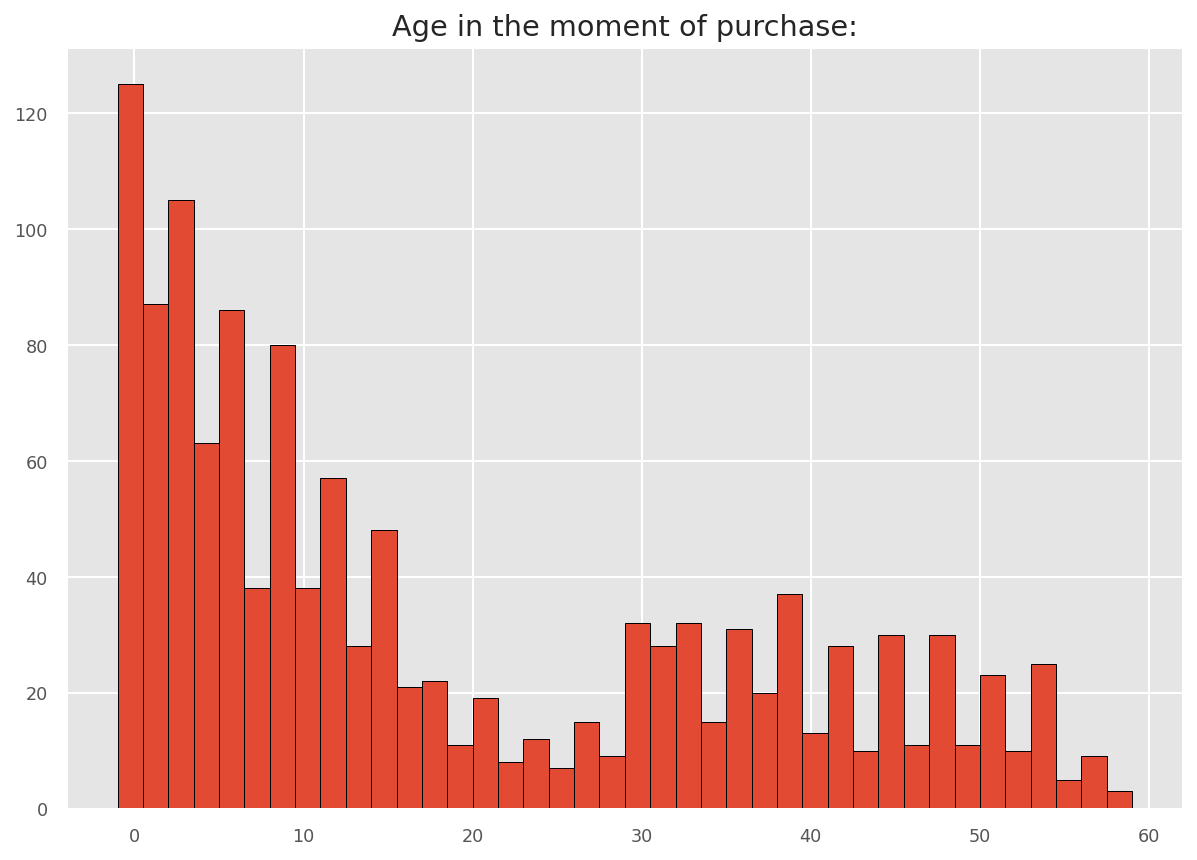

In [256]:
hist_age = data_merged['Age'].hist(bins = 40, ec="black", figsize=(10, 7))
hist_age.set_title("Age in the moment of purchase:")

We may see that newly built houses dominate in the data set. From the following histogram, we may observe that all the transactions records come from the 2006-2010 period. For further analysis, I suggest using pre/post- crisis dummies. From the boxplot, slight drop in prices is visible in 2010, hence I will mas k te 2010 as 1 in our regression

Text(0.5, 1.0, 'Price/Year Relationship')

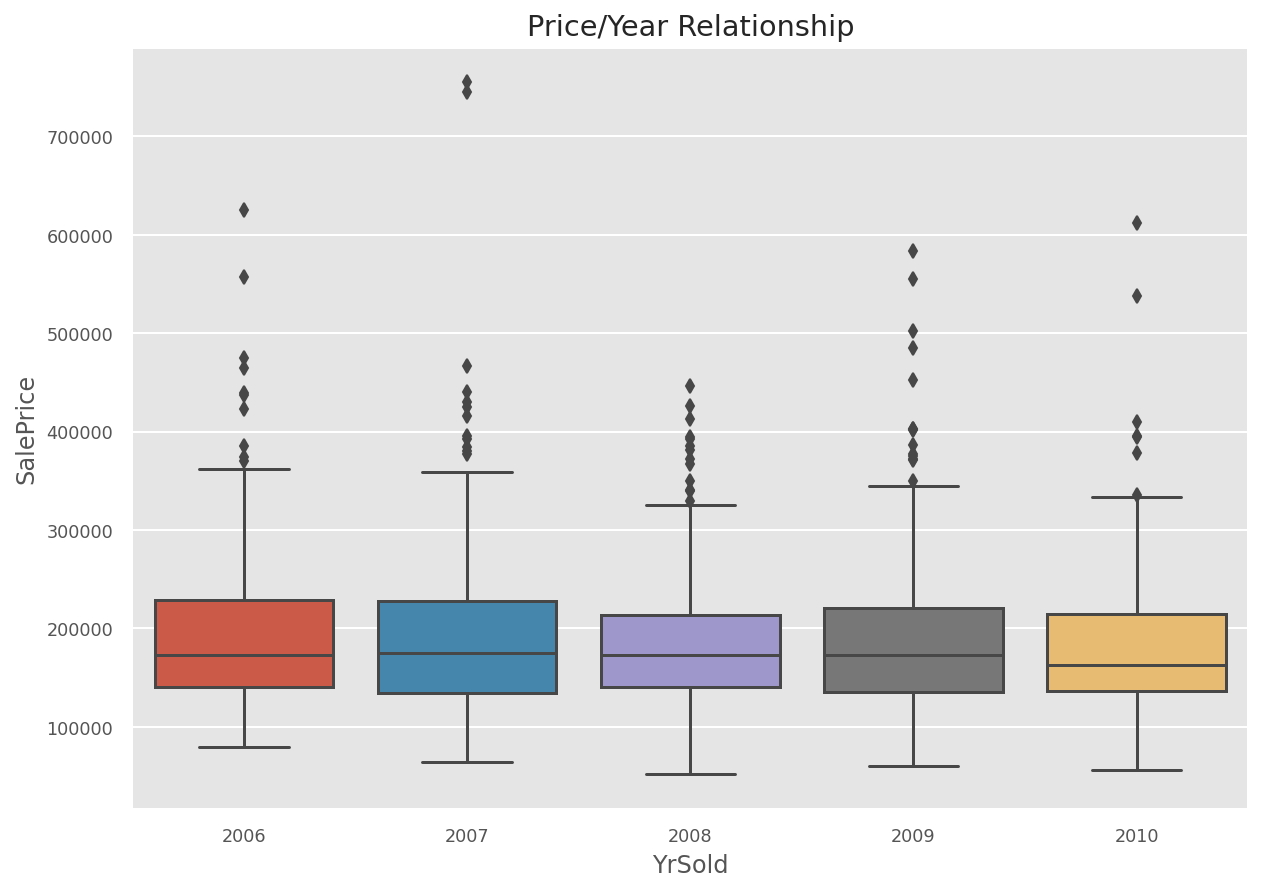

In [257]:
plt.figure(figsize=(10,7))
yr_boxplot = sns.boxplot(x=data_merged['YrSold'], y=data_merged['SalePrice'])
yr_boxplot.set_title("Price/Year Relationship")


In [258]:
def dummify(column):
  new_series = []
  for element in column:
    if element == 2010:
      new_series.append(1)
    else:
      new_series.append(0)
  return new_series

x = dummify(data_merged['YrSold'])

data_merged['crisis'] = dummify(data_merged['YrSold']) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Text(0.5, 1.0, 'Pre-post crisis effect')

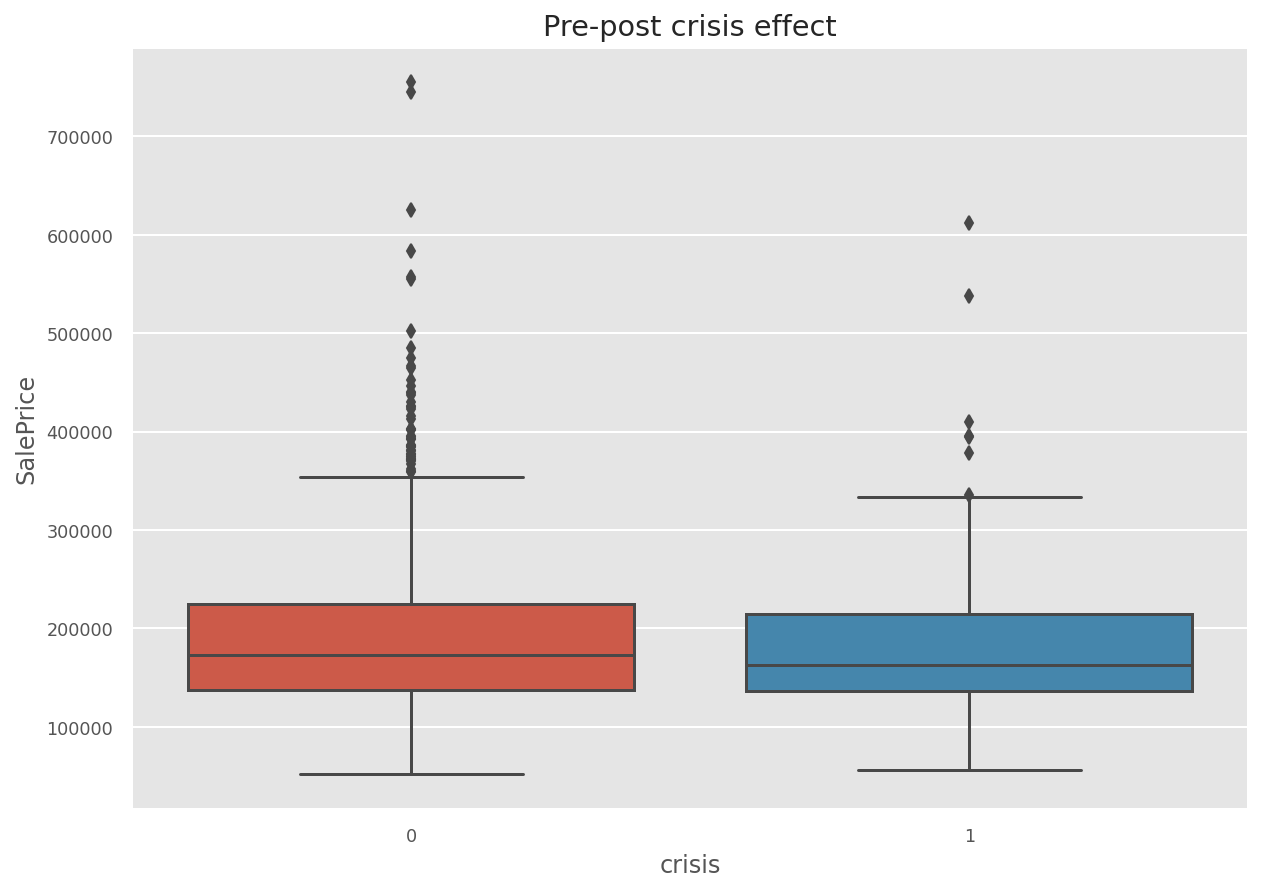

In [259]:
plt.figure(figsize=(10,7))
sns.boxplot(x=data_merged['crisis'], y=data_merged['SalePrice']).set_title("Pre-post crisis effect")

### 3.1 The Predicted Variable
Having dealt with the missing values, I will proceed to the actual assesment of our variables. Firstly, I find it useful to visualize our explained variable - house price.

Text(0.5, 1.0, 'SalePrice Histogram')

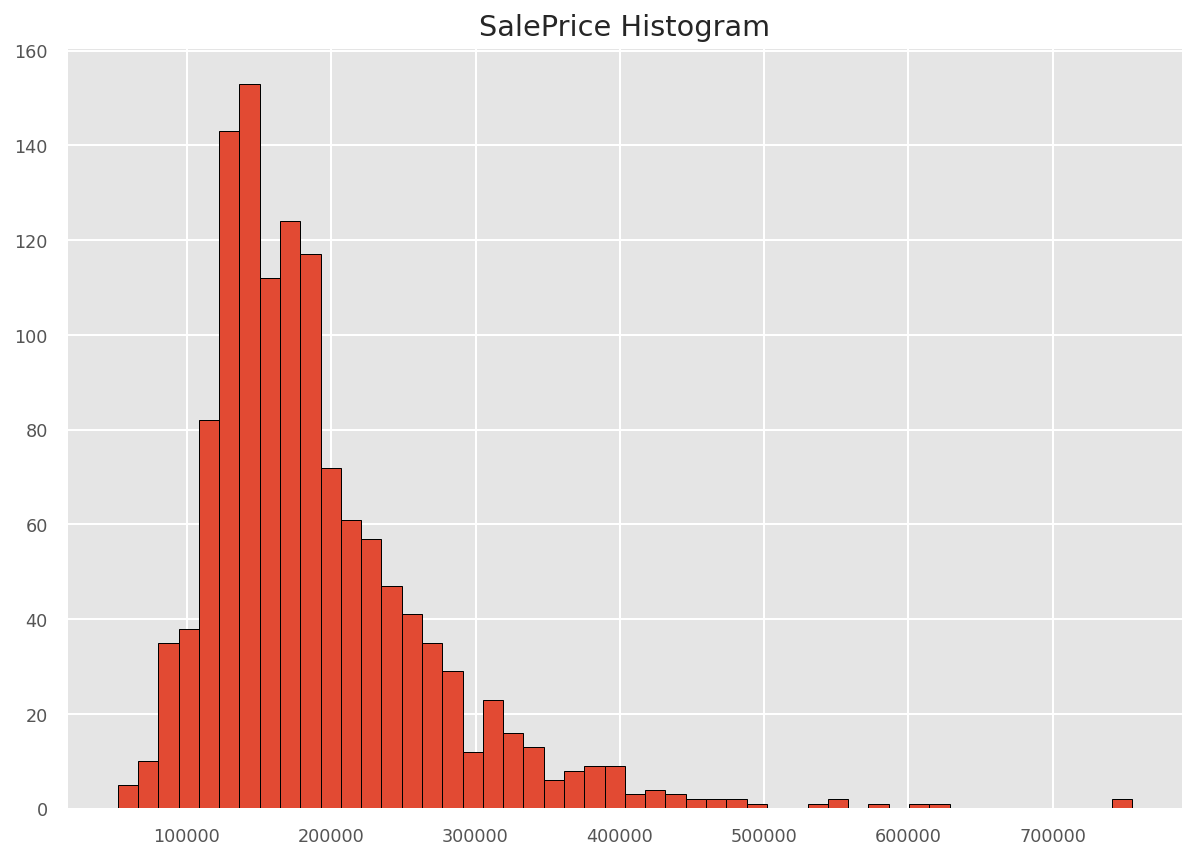

In [260]:
price_hist = data_merged['SalePrice'].hist(bins=50, figsize=(10,7), ec='black') #On the y-axis, absolute values per bin are used
price_hist.set_title("SalePrice Histogram")

We may see that our predicted variable is significantly positively skewed. In further analysis, it might be useful to remove outliers and use some form of transformation (e.g. use logarithmization of our variable). Creating a log-level model is probably the most sensitive method as we have many categorical variables which denies the possibility of using e.g. standardization using Z-score etc.  
The following cell finds the outliers of >3 StdDev magnitude. Because of the skewness, it is not surprising that our dataset contains only positive outliers.  

In [261]:
print("Number of 'SalePrice' outliers > 3StD.:", data_merged.SalePrice[(data_merged.SalePrice > np.mean(data_merged.SalePrice) + 3*np.std(data_merged.SalePrice))].count())
#data_merged.SalePrice[(data_merged.SalePrice < np.mean(data_merged.SalePrice) - 3*np.std(data_merged.SalePrice))].count() #there are no negative outliers

Number of 'SalePrice' outliers > 3StD.: 19


Our dataset contains both categorical and continuous variables. At this point, I try to explore the continuous variables which might be useful as covariates. I also assess the correlation matrix of our variables to prevent the multicollinearity - of each pair of correlated variables, only one should be incorporated to our regression.

### 3.2 Regressors Selection - Continuous Variables

#### 3.2.1 Area Variables
At this point, I will try to indentify the most appropriate regressors for our case. One of the most important features of any house is the disposable space. 
Althoug our dataset contains very detailed information on size features, I find it appropriate to select predominantly the most general variables (i.e. total area rather than its sub-categories, such as area for each floor). In our case, BasementArea is just a sum of other basement-area-related variables and GrLivArea as well.
This feature is represented e.g. by following variables:   
+ **GrLivArea** - above ground sq feet
+ **TotalBsmtSF** - basement sq feet
+ **LotArea** - lot sq feet
+ **GarageArea** - sq feet of the garage

The relationship may be assessed using scatterplots. Unsurprisingly, it is apparent that all variables have positive effect on the final sale price.  
From our scatterplots, we may assess the relationships between our prospective covarites. Especially *GarageArea* and *BasementArea* seem to be highly dependent on each other. We should incorporate this finding in our later regression.


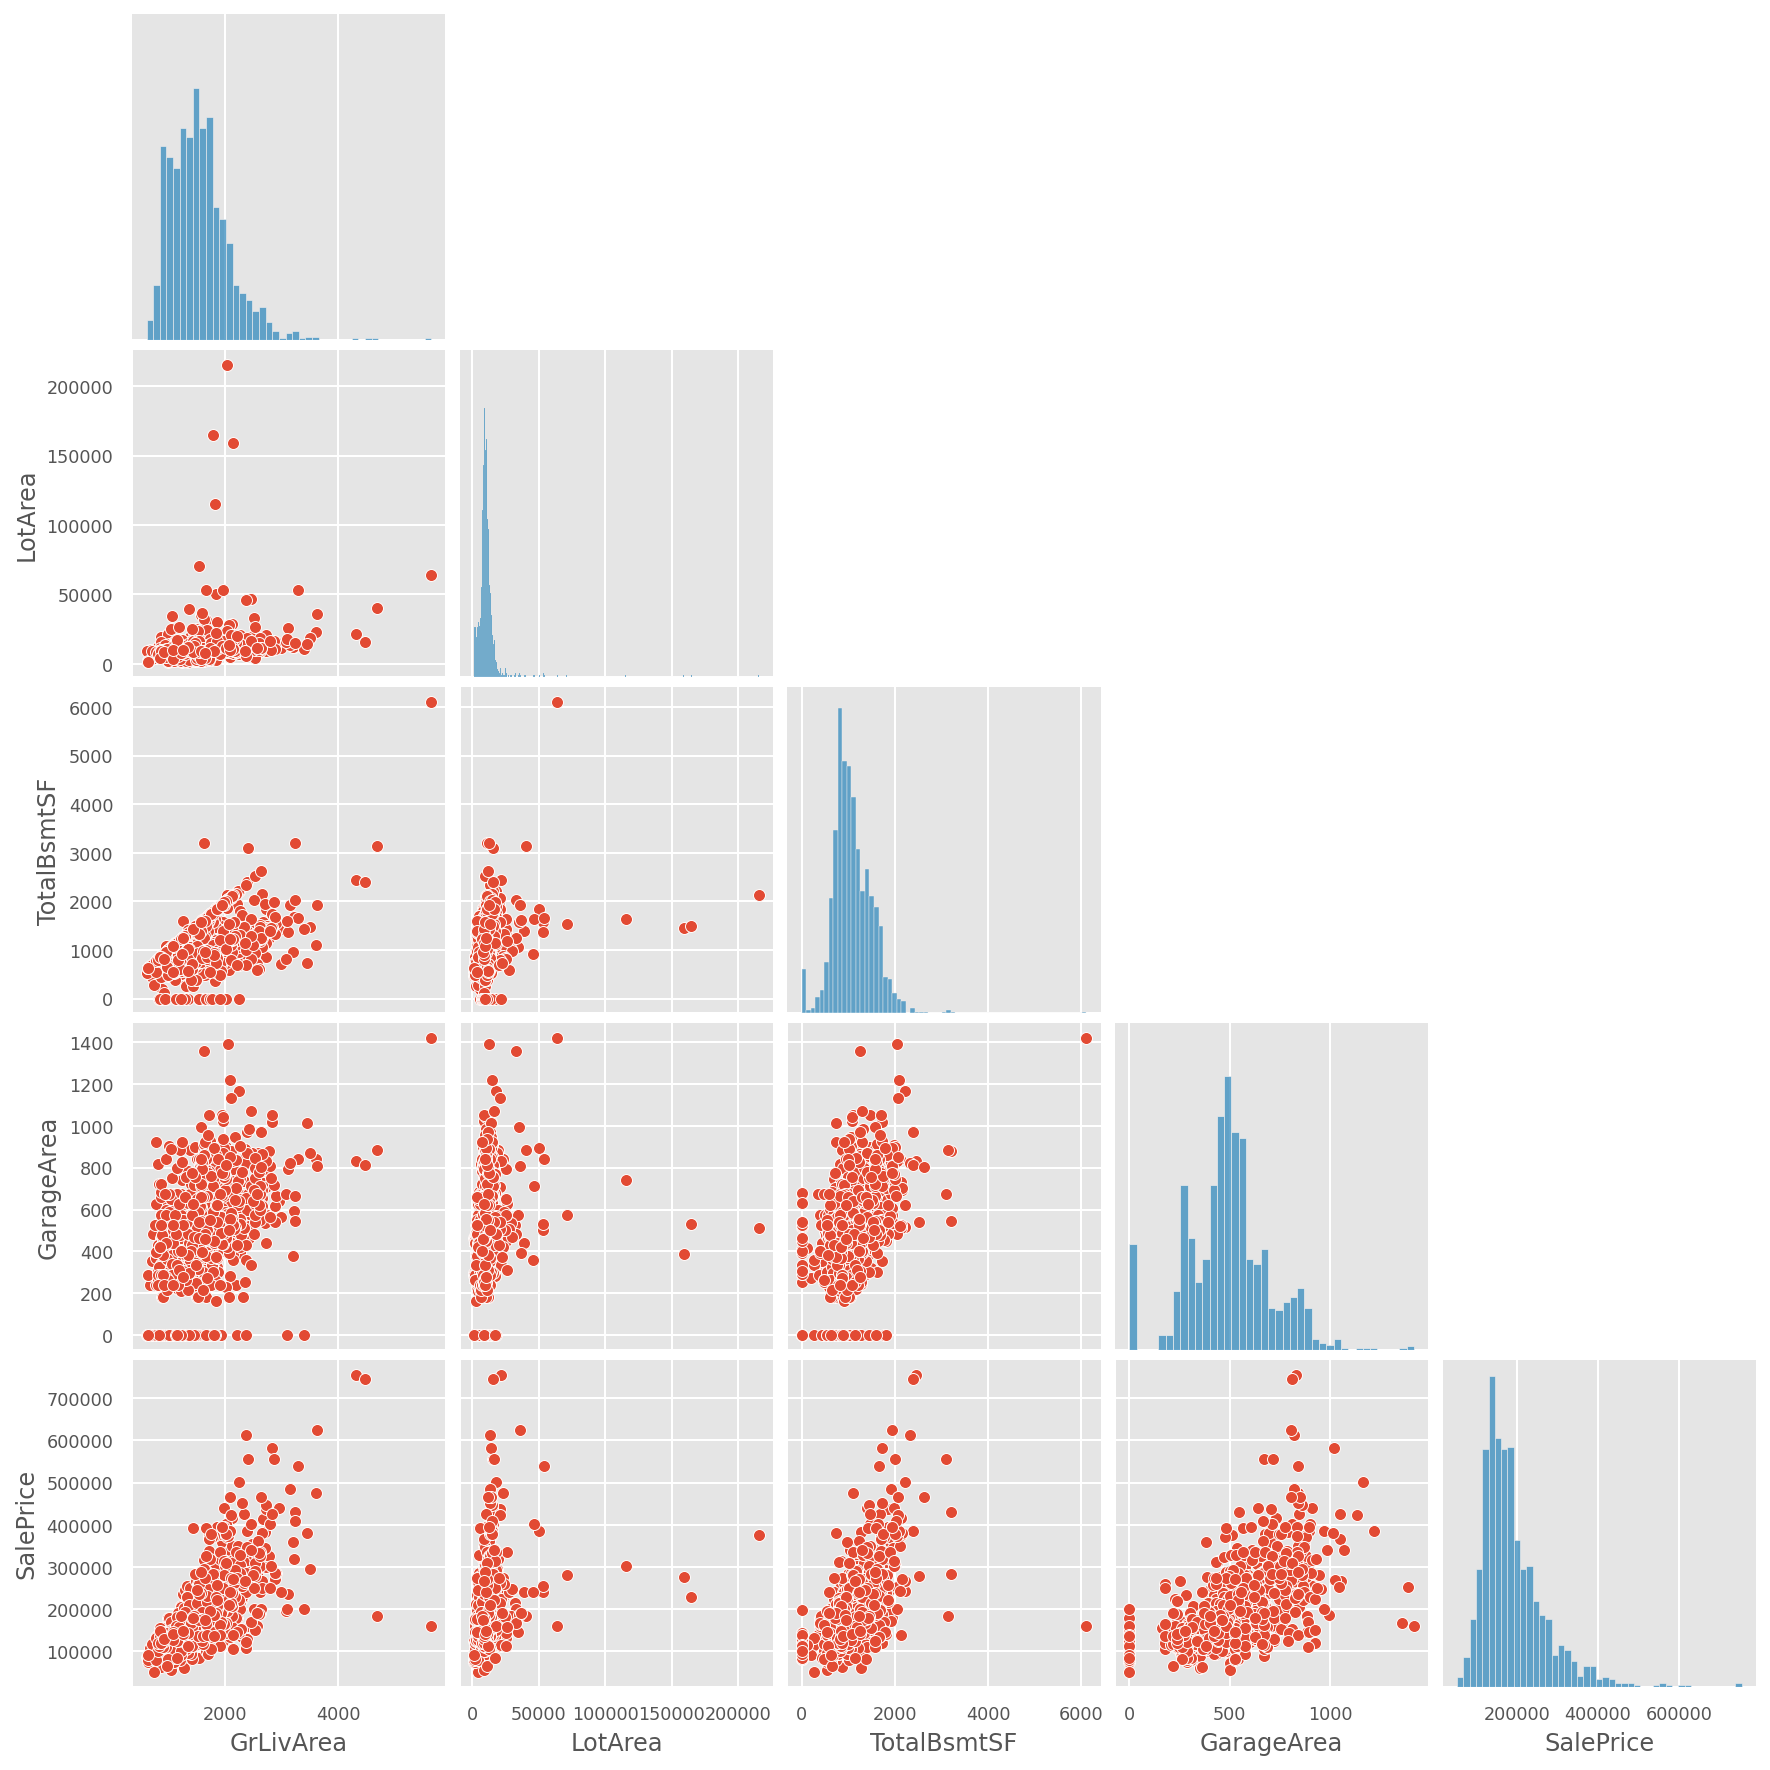

In [262]:
#data_merged = data_merged[~data_merged.index.duplicated()]
pair_cont = sns.pairplot(data_merged[['GrLivArea', 'LotArea', 'TotalBsmtSF', 'GarageArea', 'SalePrice']], corner=True)

It is apparent that the SalePrice is positively influenced by all of the above mentioned covariates. Again, for our analysis it will be useful to remove outliers as they differ significantly from prevalent linear relationship (the marginal effect of size is decreasing in scale).   
I would like to emphasize that through interactions between covariates, the total effect might substantially differ from our expected results. Let's estimate a regression model based purely on our 'space' variables:

In [263]:
print("Correlation Matrix LotArea - GrLivArea:")
data_merged[['LotArea', 'GrLivArea']].corr()

Correlation Matrix LotArea - GrLivArea:


,LotArea,GrLivArea
LotArea,1.000000,0.258265
GrLivArea,0.258265,1.000000


The above shown regression table shows that 'Space variables' alone can explain up to 66 % of our data's variability which shows their substantial relevance to our model. All of the covariates are significant except for the LotArea (which is quite odd). My former supposition that collinearity with GrLivArea is present is not right as we see from the correlation matrix.

I will further examine other possible covariates which could possibly improve our results.

#### 3.2.2 'House Condition Variabless' Variables  

Except for the variables concerned with available space, there are other variables which might be interpreted in either continuous or cardinal manner.  

+ OverallQual (rating 1-10)
+ OverallCond (probably highly collinear with OverallQual, I will select the better regressor
+ YearBuilt
+ YearRemodAdd 
+ YrSold  

I suggest adding other variable 'Age' as a difference between the date of building (or makeover) and the date of purchase. This variable is more easily interpretable than mere 'Year' variables. Further - its marginal effects will be stronger as the 10 yrs - 1 yr difference is more substantial than 2010 - 2000 differece.   
I have noticed that surprisingly high number of buildings have been rebuilt in 1950 which is almost surely a noise in our data. This should also be kept in mind in our further analysis.




In [264]:
data_merged[['OverallQual', 'OverallCond']].corr()

,OverallQual,OverallCond
OverallQual,1.00000,-0.18408
OverallCond,-0.18408,1.00000


Quite surprisingly, overall quality ando overall condition are not correlated.  

In [265]:
data_merged['Age'] = data_merged['YrSold'] - data_merged['YearRemodAdd']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [266]:
# def rebuilt_dummy(col_built, col_renovated):
#   rebuilt = []
#   for i in range(1, len(col_built) + 1):
#     if col_built[i] == col_renovated[i]:
#       rebuilt.append(1)
#     else:
#       rebuilt.append(0)
#   return rebuilt

# data_merged['rebuilt'] = rebuilt_dummy(data_merged['YearBuilt'], data_merged['YearRemodAdd']) #hereby I create the dummy whether the house has been rebuilt


#### 3.2.3 'Feature' Variables  
To capture the actual effect of our 


To make our analysis more comprehensive, i also create new variables as a sum of partial features, such as total number of rooms, fireplaces etc.

In [267]:
data_merged['bathrooms_tot'] = data_merged[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']].sum(axis=1) #create a variable of total bathrooms

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 3.3 Regressors Selection - dealing with categorical variables
Having assessed the continuous variables in our dataset, I will further move to the categorical ones. There are about 40 such variables in our dataset, again many of them are less significant. I list them below:

In [268]:
data_merged.select_dtypes(include="object").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1282 entries, 1 to 1460
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1282 non-null   object
 1   Street         1282 non-null   object
 2   LotShape       1282 non-null   object
 3   LandContour    1282 non-null   object
 4   Utilities      1282 non-null   object
 5   LotConfig      1282 non-null   object
 6   LandSlope      1282 non-null   object
 7   Neighborhood   1282 non-null   object
 8   Condition1     1282 non-null   object
 9   Condition2     1282 non-null   object
 10  BldgType       1282 non-null   object
 11  HouseStyle     1282 non-null   object
 12  RoofStyle      1282 non-null   object
 13  RoofMatl       1282 non-null   object
 14  Exterior1st    1282 non-null   object
 15  Exterior2nd    1282 non-null   object
 16  MasVnrType     1274 non-null   object
 17  ExterQual      1282 non-null   object
 18  ExterCond      1282 non-null

There are also some variables which seem to influence our possible results - e.g. SaleCondition seems to have an impact on our target variable. We may see that 'Partial' SaleCondition is signifiantly different from other conditions of sale. This is the case of houses which have been purchased prior to their completion. Also the category 'Family' might cause some spuriousness in our data as such transactions will be supposedly of lower magnitude for ceteri paribus the same house.


Text(0.5, 1.0, 'Price/SaleCondition Relationship')

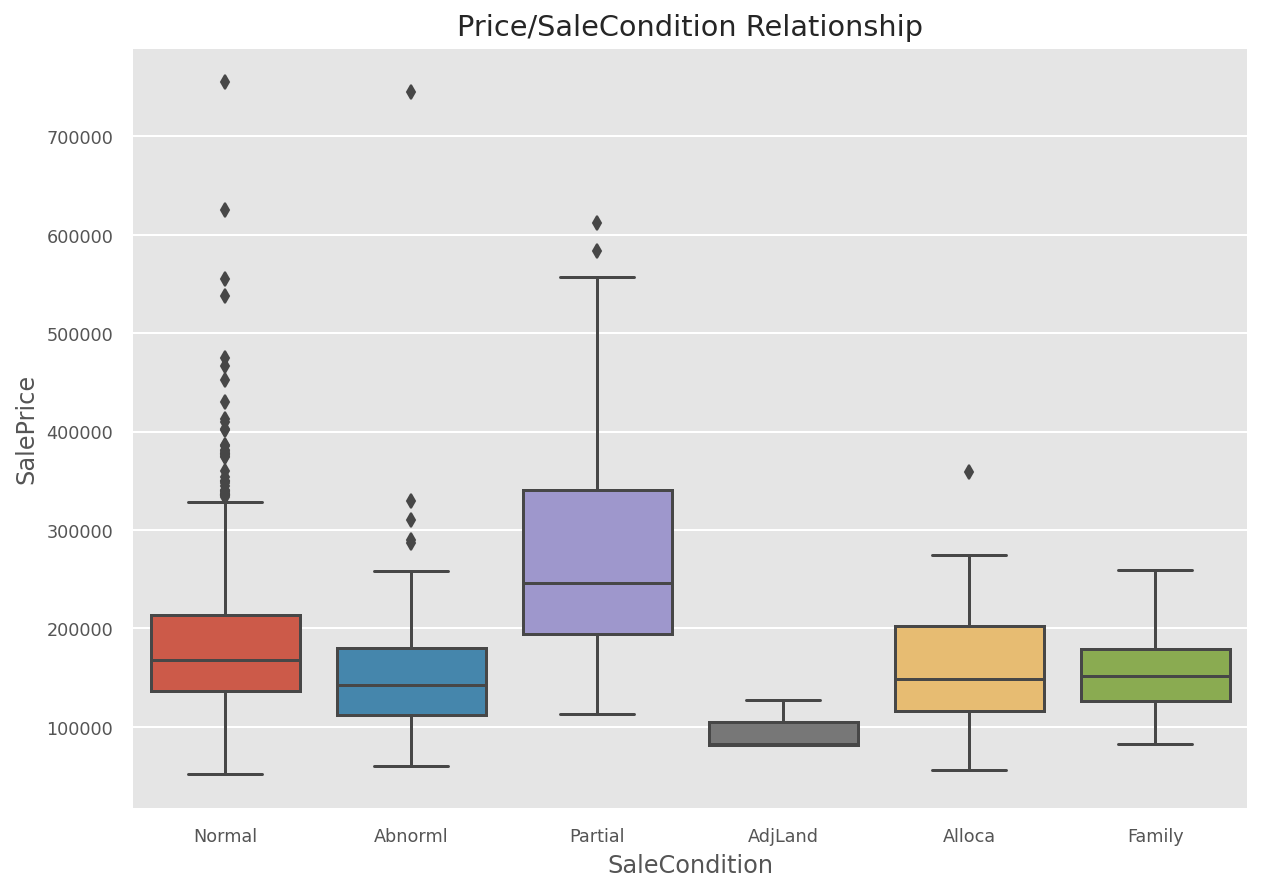

In [269]:
plt.figure(figsize=(10,7))
sns.boxplot(y=data_merged['SalePrice'], x=data_merged['SaleCondition']).set_title("Price/SaleCondition Relationship")

In [270]:
data_merged['SaleCondition'].value_counts()

Normal     1048
Partial     124
Abnorml      80
Family       15
Alloca       12
AdjLand       3
Name: SaleCondition, dtype: int64

Apparently 'normal' transactions prevail in our case, hence we do not need to reflect this in our regression. I would suggest masking the 'normal' as 0 and the 'partial' as 1. Hereby we can exclude the abnormal transactions and also control for transactions which were contracted before the building's completion


In [271]:
def sale_cond_dummified(column):
  dummy = []
  for element in column:
    if element == 'Normal':
      dummy.append(0)
    elif element == 'Partial':
      dummy.append(1)
    else:
      dummy.append(None)
  return dummy

data_merged['cond_dummy'] = sale_cond_dummified(data_merged['SaleCondition'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Text(0.5, 1.0, 'Price/Condition relationship')

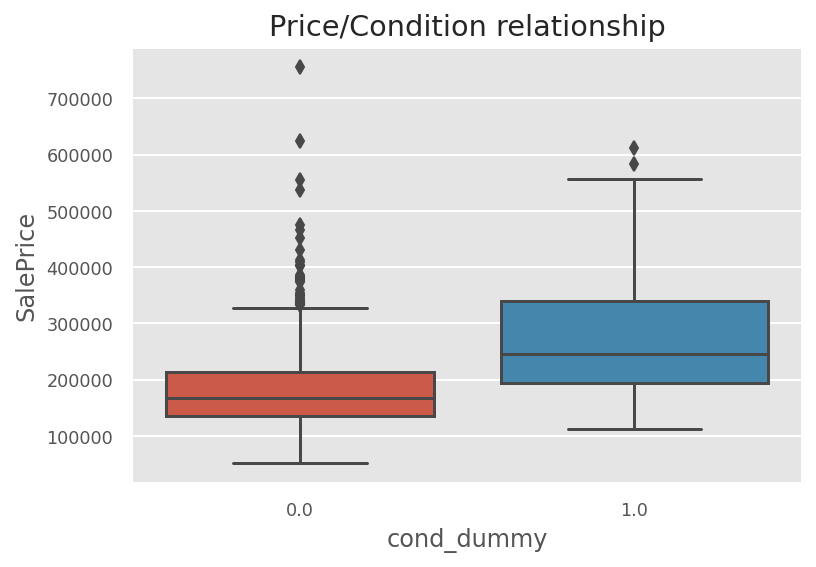

In [272]:
sns.boxplot(x=data_merged['cond_dummy'], y=data_merged['SalePrice']).set_title("Price/Condition relationship")

Another important factor to our analysis might be the role of neighbourhood. As the 'real estate golden rule' number one states: LOCATION, LOCATION, LOCATION! It is therefore tempting to introuce the neigborhood factor as it incorporates otherwise hardly reflectable social factors to our regression.*italicized text*

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

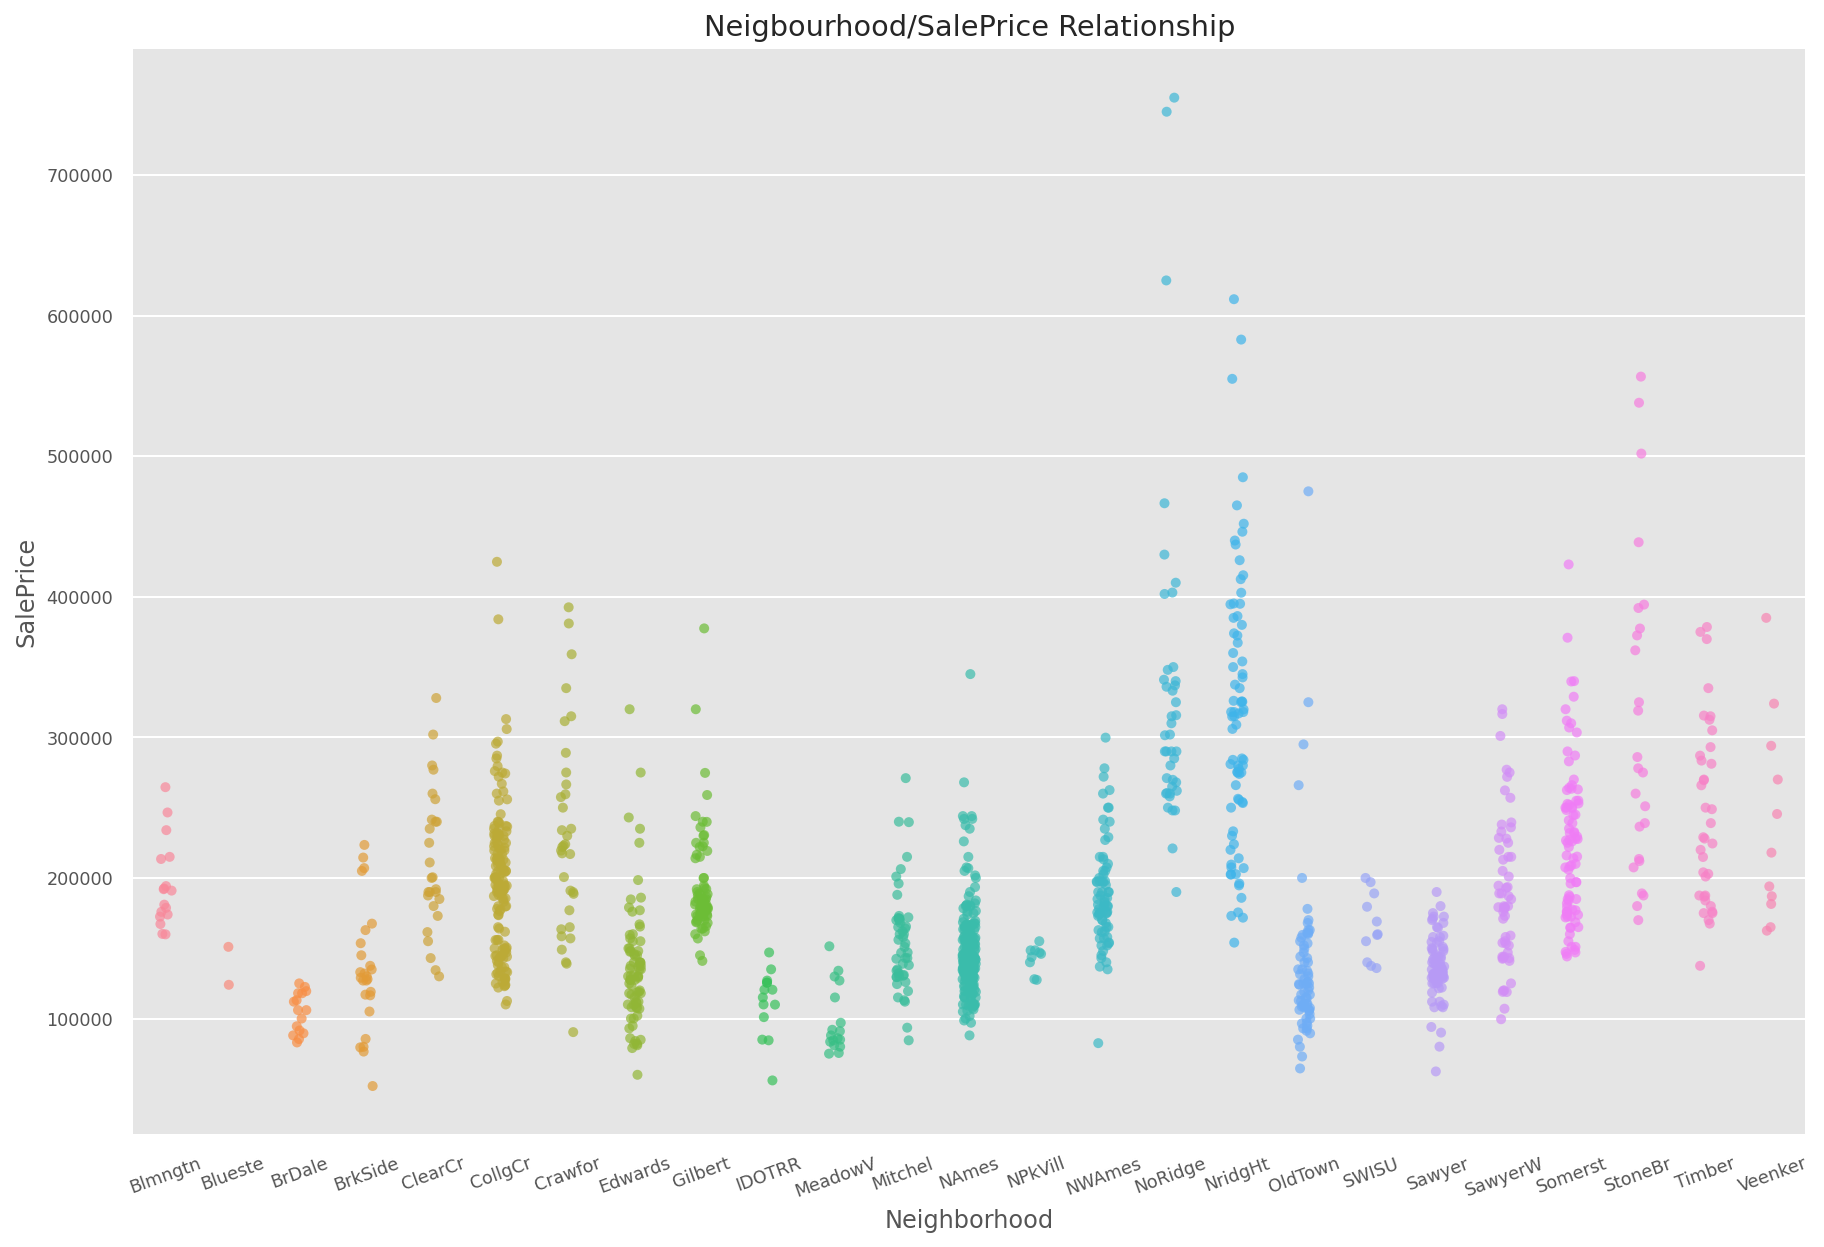

In [273]:
fig, ax = plt.subplots(figsize=(15,10))

sns.stripplot(x=data_merged.Neighborhood, y=data_merged.SalePrice,
              order=np.sort(data_merged.Neighborhood.unique()),
              jitter=0.1, alpha=0.7)
plt.title('Neigbourhood/SalePrice Relationship')
plt.xticks(rotation=20)

It is apparent that neighborhood plays significant role in the price-setting process. We could possibly use e.g. One-Hot Encoding to reflect it in our regression. However, potential incorporating of such variable is quite problematic for two main reasons:
 
+ **neighborhoods differ substantially in terms of observations**
+ **multicollinearity between similar neighborhoods**   

For  the above mentioned reasons, I decided to omit this feature in the regression. If the fit seems to be poor, this might be a point which might be further elaborated.

Except for factors such as neigborhood, I introduce dummies to control for the presence of air conditioning. 

In [274]:
data_merged['aircond'] = pd.get_dummies(data_merged['CentralAir'])['Y']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Other possibly important feature might be the presence of a pool. However, the total number of pools is really low. I do therefore ommit this feature in further analysis. There are other possibly influential categoriacal variablesm such as 'Utilities' which sufer from significant unequality of observations across categories.  
Other possibly important feature migth be the proximity of railroads or highways as various studies have shown their negative impact. I will create a dummy for this factor to our analysis. I consider it as sufficient to reflect only the Condition1:

In [275]:
def traffic(x):
    # if 'Artery' in x:
    #     return 1
    # elif 'RRAn' in x:
    #     return 1
    # elif 'RRNn' in x:
    #     return 1
    # elif 'RRAe' in x:
    #     return 1
    # elif 'RRNe' in x:
    #     return 1
    # else:
    #     return 0
    if x in ['Artery','RRAn','RRNn','RRAe','RRNe']:
      return 1
    else:
      return 0

data_merged['traffic_dummy'] = data_merged.Condition1.map(traffic)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 4 Regression 

Let's move on to the actual regression analysis.Firstly, I would like to justify and describe my approach. Because I am supposed to construct a predictive model, I will use a 'ML' approach rather than the 'econometric' one. What do I mean by this? I will use a train/test split and subsequent testing through various metrics (such as cross-validation as well as RMSE) of our data in order to select the best possible predictive model.  
Clssica laproach in the econometric way would rather focus on the covariates' effects and test hypotheses set before the actual regression analysis.

### 4.1 Data frame transformation

Before the acual analysis, I will implement the suggested changes to the data frames, i.e. dropping the insignificant features, missing values and so on. From the above construed dummy variables, by running the regression several times, I do keep only the 'traffic' and 'air conditioning' dummy variables. Besides, I use the 

In [276]:
df_tidy = data_merged[['SalePrice','GrLivArea', 'TotalBsmtSF','GarageArea', 'LotArea', 'Age', 'bathrooms_tot', 'aircond','traffic_dummy', 'TotRmsAbvGrd', 'Fireplaces', 'OverallQual','OverallCond']]
# Selecting the significant features of our dataset

In [277]:
df_tidy.describe()
df_tidy.shape

(1282, 13)

I will also drop the outliers of our target variable which have been identified above.

In [278]:
df_tidy = df_tidy[(np.abs(stats.zscore(df_tidy['SalePrice'])) < 3)] #hereby I drop the observations of supposedly overpriced houses

The following heatmap shows whether any of our explanatory variables exhibit high correlation - in such case, I would drop the supposedly less significant variable before doing the regression. I do so because multicollinearity might bias effects of other regressors. I set the threshold to drop a variable at 0.7 which means that I have dropped 'TotRmsAbvGrd'.

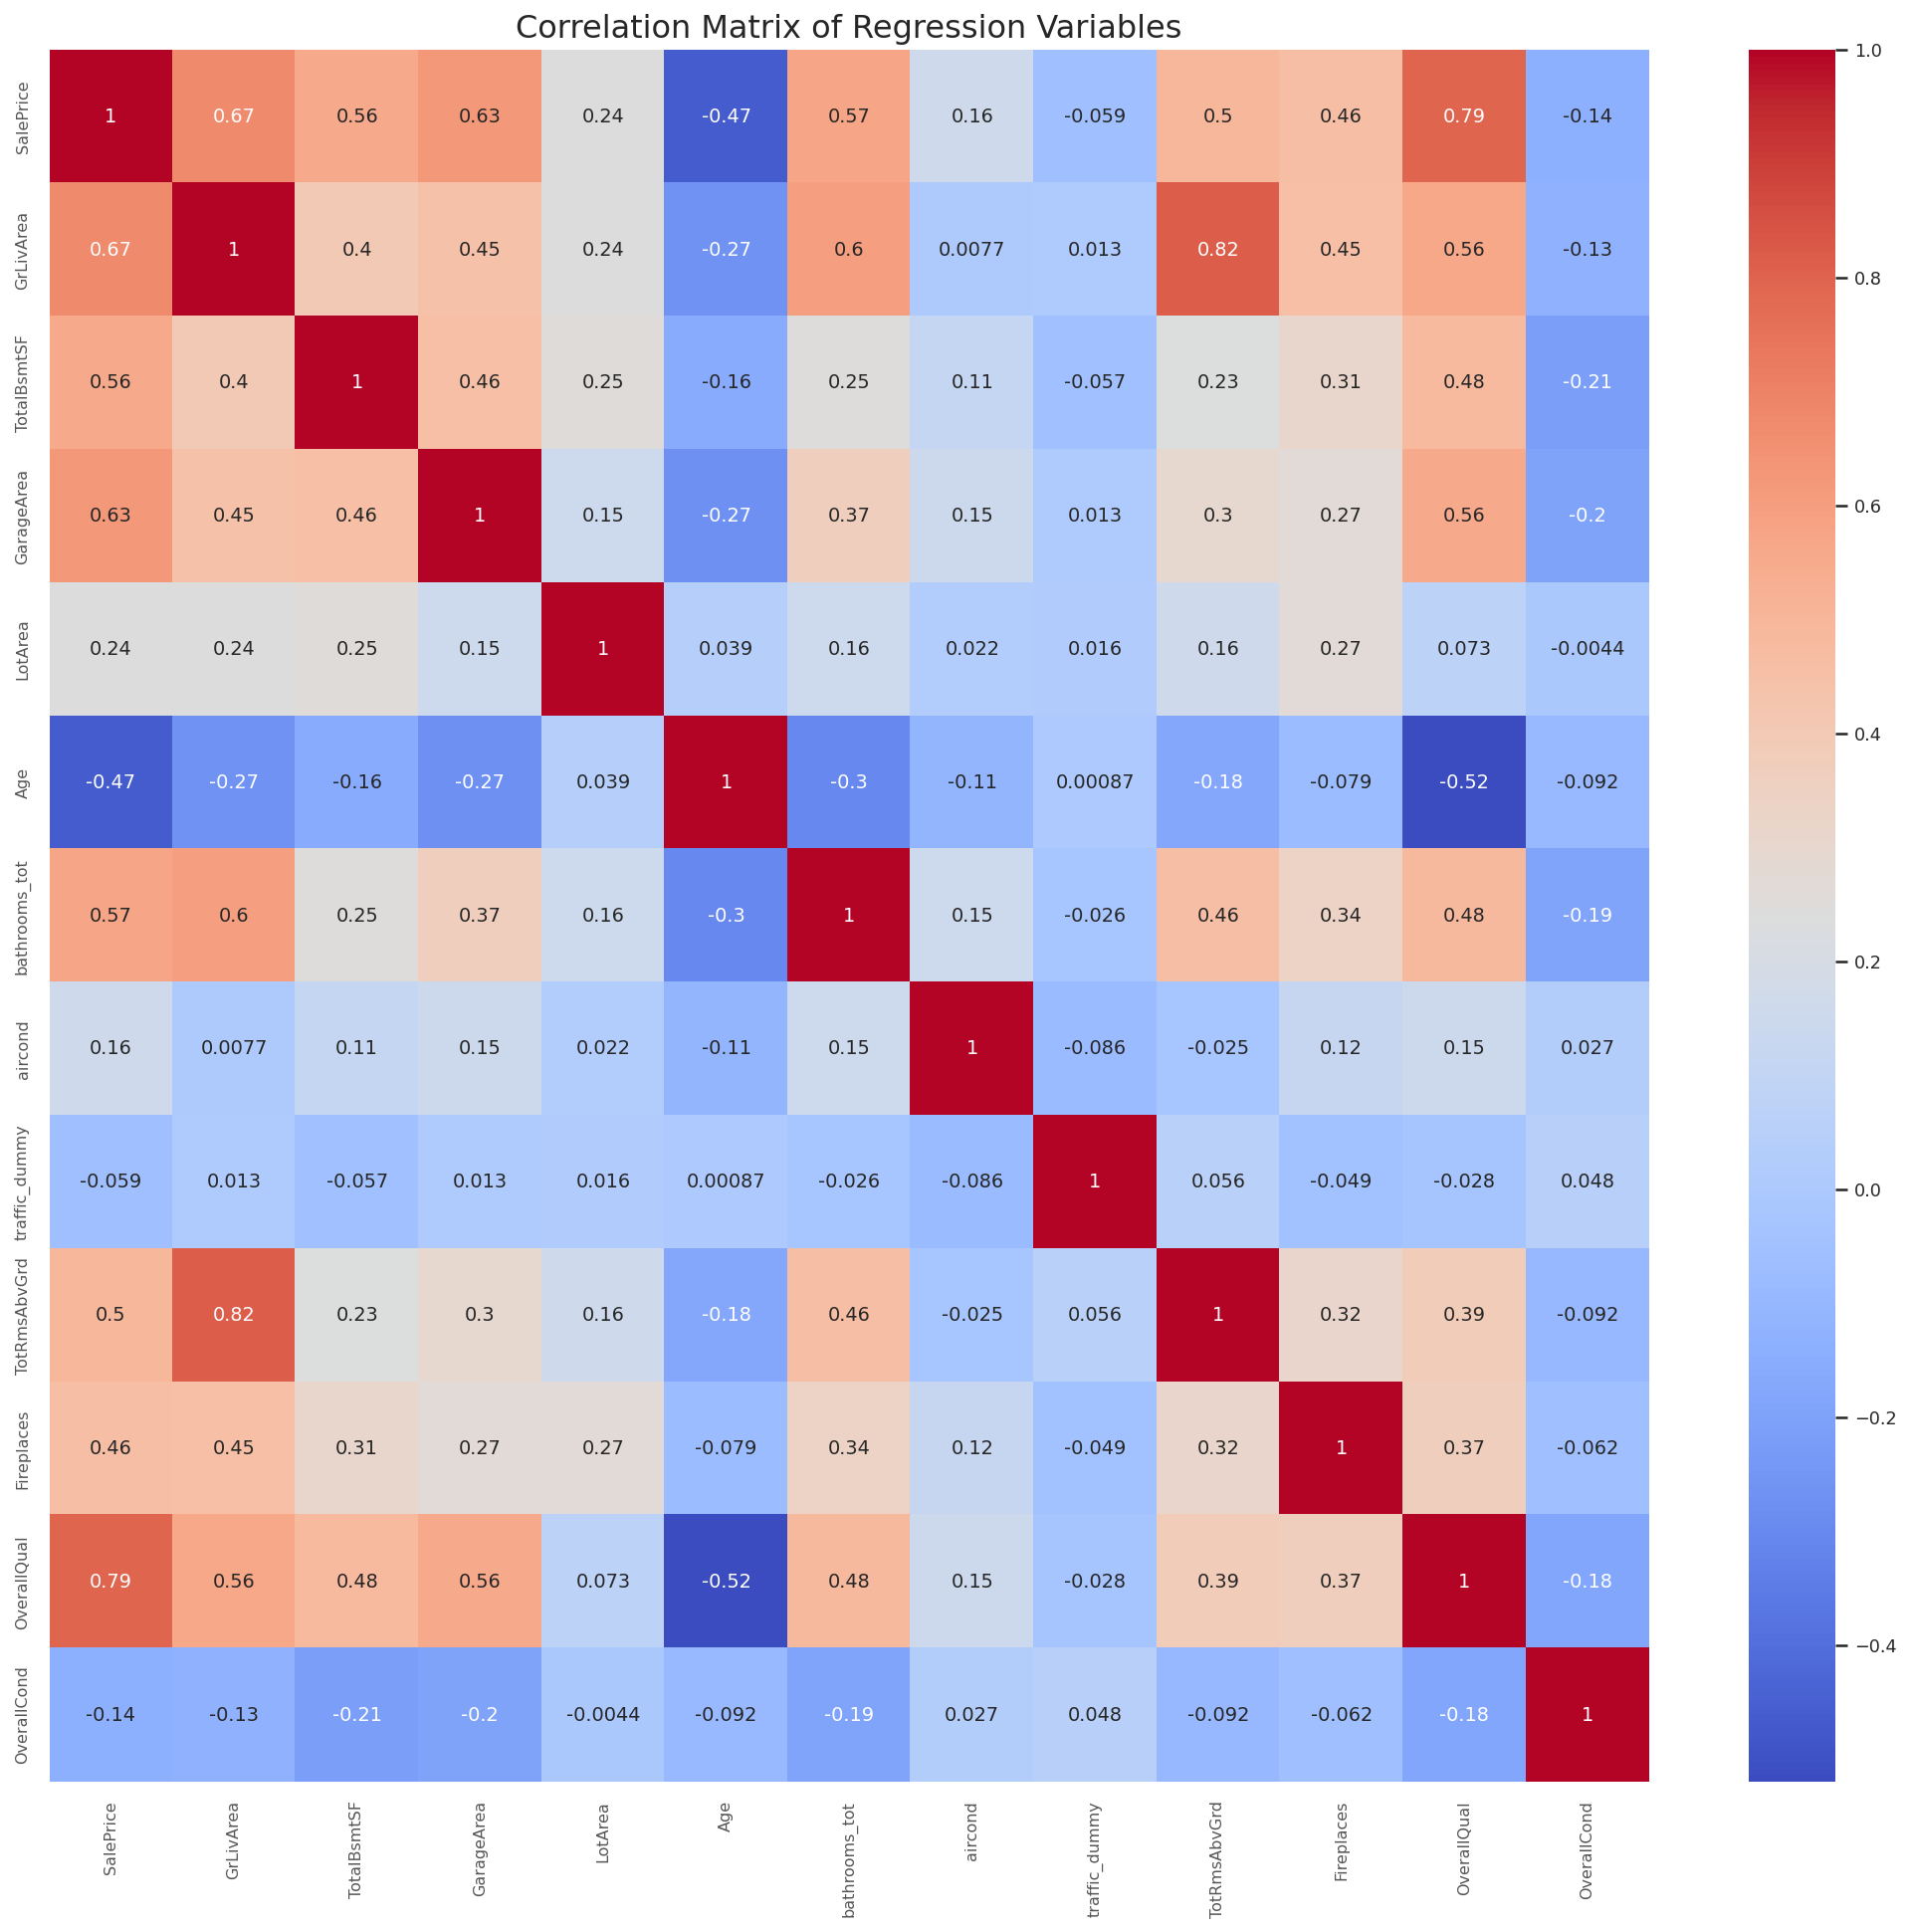

In [279]:

fig, ax = plt.subplots(figsize=(18, 16))

sns.set(font_scale=0.8)
sns.heatmap(df_tidy.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Regression Variables", fontsize=16)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=8)
plt.show()



In [280]:
X = df_tidy.drop(['SalePrice', 'TotRmsAbvGrd'], axis=1) #matrix of our explanatory variables
y = df_tidy['SalePrice'] #explained variable

After analysing the heatmap, I will drop the 'Total Rooms Above Ground' which is unsurprisingly correlated with total living space.  
Let's move on to creating the train/test datasets.

In [281]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)


To fit the OLS model to our data, I use sklearn functions. In the next step, I initialize the standard OLS model and fit it to the train data

In [282]:
X_test.describe()

,GrLivArea,TotalBsmtSF,GarageArea,LotArea,Age,bathrooms_tot,aircond,traffic_dummy,Fireplaces,OverallQual,OverallCond
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,1517.564644,1059.477573,484.118734,10390.738786,18.002639,2.506596,0.968338,0.050132,0.646438,6.182058,5.577836
std,477.248211,386.317400,191.140324,9243.879334,16.889541,0.880015,0.175331,0.218506,0.631247,1.274950,1.049633
min,630.000000,0.000000,0.000000,1477.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,2.000000
25%,1150.000000,836.500000,388.000000,7500.000000,4.000000,2.000000,1.000000,0.000000,0.000000,5.000000,5.000000
50%,1484.000000,1040.000000,480.000000,9560.000000,11.000000,3.000000,1.000000,0.000000,1.000000,6.000000,5.000000
75%,1792.000000,1288.500000,576.000000,11592.000000,32.500000,3.000000,1.000000,0.000000,1.000000,7.000000,6.000000
max,3194.000000,2158.000000,1220.000000,159000.000000,57.000000,5.000000,1.000000,1.000000,2.000000,10.000000,9.000000


In [283]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

In [284]:
print("The Adjusted R Squared Value: ", ols.score(X_train, y_train))

The Adjusted R Squared Value:  0.7686965172172558


We may see that using a level-level gives us about 77 % of explainability in our dataset through our regression. Looking at the QQ plot, we may see that residuals' dffer from the normal distribution. I will therefore use a logarithmization of a target variable. After the logarithmization, istogram follows approximately a normal distribution

Text(0.5, 1.0, 'log SalePrice Histogram')

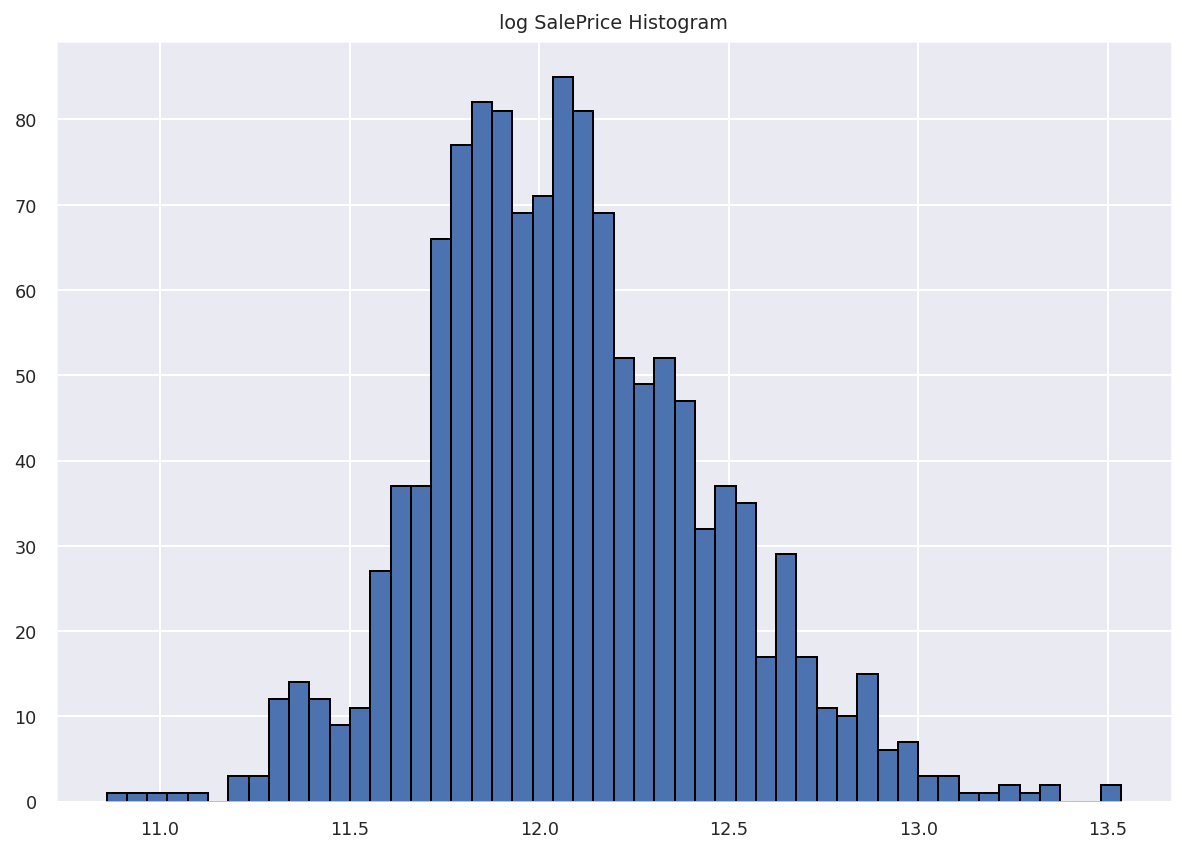

In [285]:
price_hist = np.log(data_merged['SalePrice']).hist(bins=50, figsize=(10,7), ec='black') #On the y-axis, absolute values per bin are used
price_hist.set_title("log SalePrice Histogram")

Now it;s time to evaluate our model. The standard approach would be to use adjusted R squared metrics. I prefer to select between different models and specifications rathr on train/test methodology. At first, I will check how good is our model at predicting the 'test' values.



We may see that residuals follow the normal distribution a bit more. This supports an argument that further modifications of model in terms of log or level specification must not be needed.  
In the following cells, I define functions to compute evaluation metrics.

In [343]:
# cross validation:
def train_scores(model, X, y):
    '''
    This function is meant to compute evaluate our models according to a 3-fold 
    cross validation over the train set

    model: fitted model
    X: Matrix of explanatory variables (train set)
    y: Dependant variable (train set)
    '''
    cv_scores = cross_val_score(model, X, y, cv=3) #CV function

    print('Training Score:', np.round(model.score(X, y), 4)) # R Squared
    print('Cross-validation scores:', np.round(cv_scores, 4)) #CV function
    print('Mean cross-validation score:', np.round(cv_scores.mean(), 4)) # AVG CV score


In [344]:
def test_scores(model, X, y):
    '''
    Computes the R Squared metrics over the test set

    model: fitted model
    X: Matrix of explanatory variables (test set)
    y: Dependant variable (test set)
    '''
    print('Test Score:', np.round(model.score(X, y), 4))


In [345]:
def accuracy_scores(model, X, y):
    '''
    Computes the Mean squared predictions error both in MSE and RMSE
    
    model: fitted model Object
    X: Covariates matrix (test set) 
    y: Dependent variable (test set)
    '''
    yhat = model.predict(X)
    print('MSPE: ', np.round(metrics.mean_squared_error(y, yhat), 4)) 
    print('RMSPE: ', np.round((metrics.mean_squared_error(y, yhat))**0.5, 4)) 

The following cells outputs two metrics which could be of use when comparing different models with same arguments but different methods In our case, when I use only the OLS, these are of little use per se.

In [346]:
accuracy_scores(ols, X_test, y_test)


MSPE:  872398026.0752
RMSPE:  29536.3848


In [347]:
predictions_train = ols.predict(X_train)
predictions_test = ols.predict(X_test)


In [348]:
ols_residuals_test = y_test - predictions_test


To assess predictive abilities of our model, I also use a scatterplot of predictions vs OLS residuals. We might see 

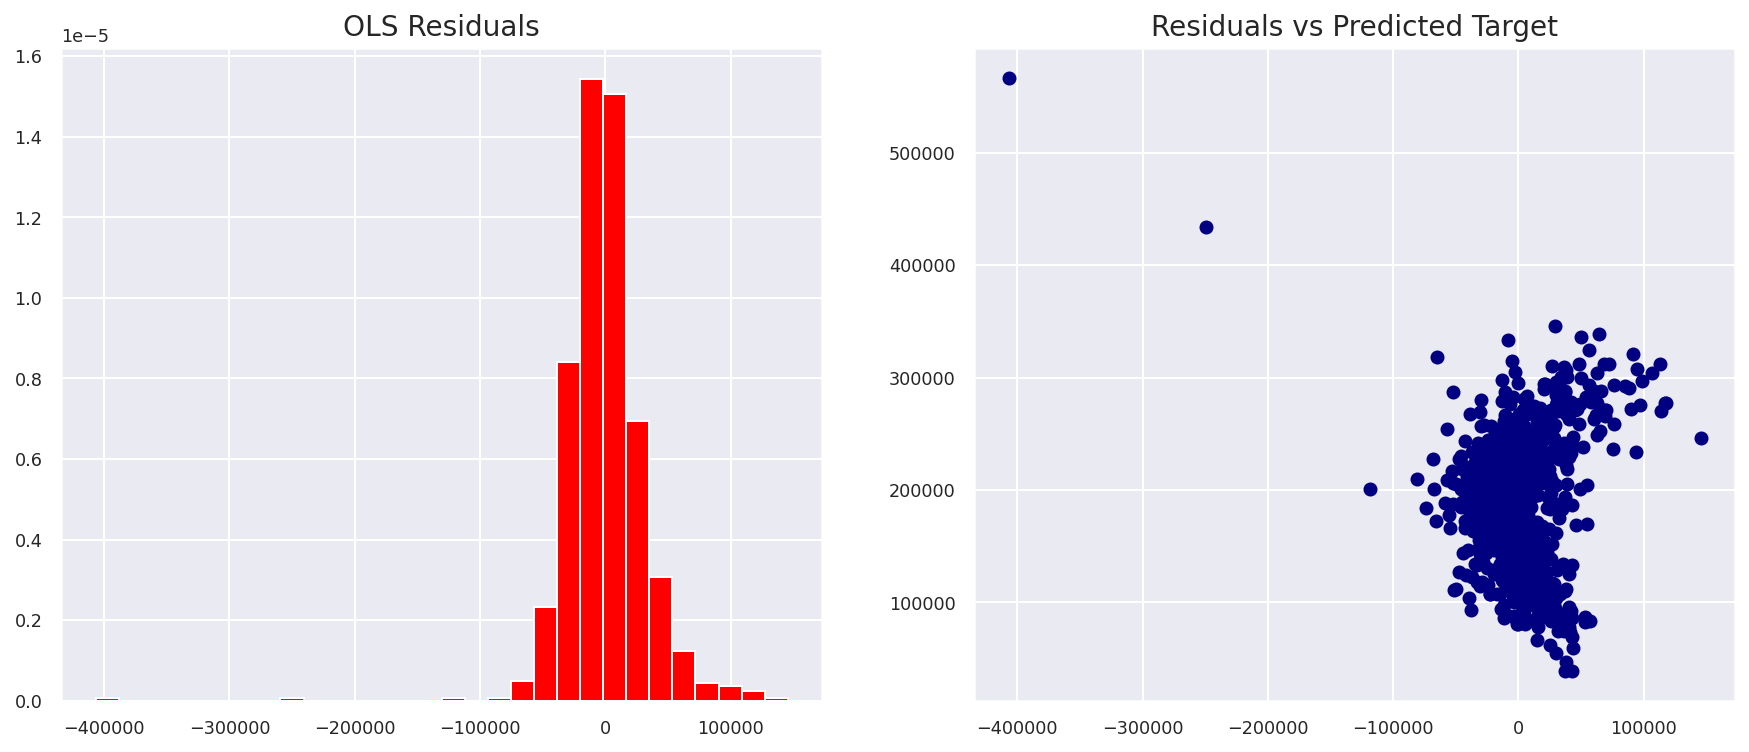

In [349]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
ax[0].hist(ols_residuals, density=True, bins=30, color='red')
ax[0].set_title('OLS Residuals', fontsize=14)
ax[1].scatter(ols_residuals, predictions_train, color='navy')
ax[1].set_title('Residuals vs Predicted Target', fontsize=14);

From the plot on the right hand size we might assess (and again it is not surprising) that residuals' variance grows in rising house price.

To continue the residuals' analysis, I also drew a QQ plot of residuals. From the fact that residuals are qpprox. normally distributed (follow the red line) we might assert that no signficant features of our model are needed.  
This still does not mean that e.g. logarithmization won't provide us with better results.  
Economic research has shown (e.g. Kahneman and Tversky in their Prospect Theory) that humans do perceive price changes rather on logarithmic scale than on linear one. I would incorporate this to our analysis as well via logarithmization of our model.

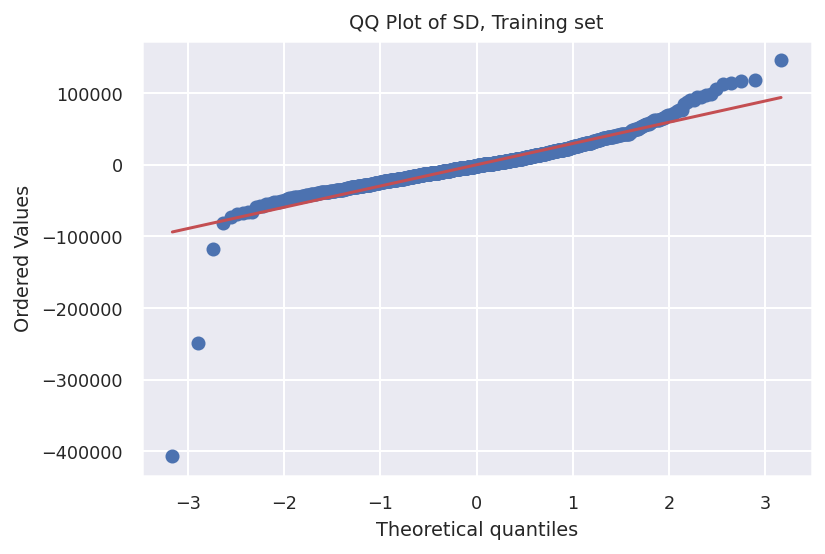

In [350]:
from scipy import stats
stats.probplot(ols_residuals, dist="norm", plot=plt)
plt.title("QQ Plot of SD, Training set");

In [351]:
log_y_train = np.log(y_train)
ols_loglevel.fit(X_train, log_y_train)

LinearRegression()

In [352]:
predictions_log_train = ols_loglevel.predict(X_train)
predictions_log_test = ols_loglevel.predict(X_test)

In [353]:
ols_loglevel_residuals = (log_y_train - predictions_log_train)
ols_loglevel_residuals.describe()

count    8.840000e+02
mean     2.109926e-16
std      1.582505e-01
min     -2.043698e+00
25%     -6.453132e-02
50%      1.354428e-02
75%      8.611097e-02
max      4.818240e-01
Name: SalePrice, dtype: float64

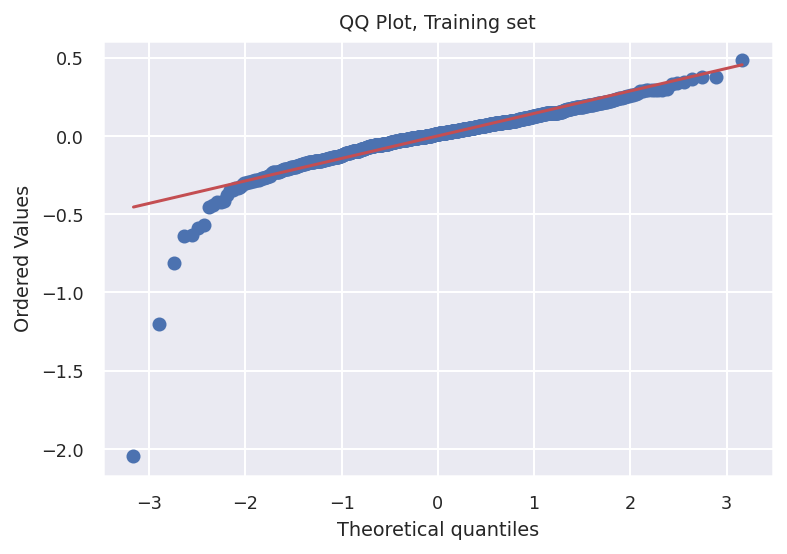

In [354]:
stats.probplot(ols_loglevel_residuals, dist="norm", plot=plt)
plt.title("QQ Plot, Training set");

We may see that logarithmization has made residuals more following the quantiles in the upper tail. Let's score the log-level model in the next step:

In [355]:
train_scores(ols, X_train, y_train)
print()
train_scores(ols_loglevel, X_train, log_y_train)

Training Score: 0.7687
Cross-validation scores: [0.6377 0.7753 0.8325]
Mean cross-validation score: 0.7485

Training Score: 0.795
Cross-validation scores: [0.6618 0.8071 0.8308]
Mean cross-validation score: 0.7666


After transforming the target variable, we may see that our fitted values behave correctly in the upper tail of the distribution. This might suggest that after logarithmization, our covariates are more capable  of describing the target variable's behavior.

The logarithmization has not significantly improved our model's predictive accuracy according to the 3-fold cross validation.

### 3.2 Concluding the Regression Analysis

To conclude this analytical part, I will use regression table and subsequently the shaply package's Waterfall plot to assess our covariates' effect on the target variable.

In [377]:
X_sm = sm.add_constant(X_train)
model = sm.OLS(log_y_train, X_sm)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     307.4
Date:                Fri, 17 Dec 2021   Prob (F-statistic):          4.73e-291
Time:                        13:38:12   Log-Likelihood:                 375.88
No. Observations:                 884   AIC:                            -727.8
Df Residuals:                     872   BIC:                            -670.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.6923      0.061    174.418

We may see that all of our regressor remain significant at least on the 0.1 level. This is not an empirical study and I do suggest keeping the 'traffic dummy' in our regression. We may state that the model is significant as a whole according to the F-test.  
All the coefficients show the marginal effect of an increase in (ceteri paribus) covariate on the target variable. T o illustrate, I will use the number of bathrooms - having an extra bathroom increases the expected price by approximately 6.9 %.  
However, this way constructed marginal effects are not easily comparable. U therefore use tha shaply 'explainable AI' feature called watterfall plot which shows the relative effect of every covariate:

In [364]:
!pip install shap

     |████████████████████████████████| 564 kB 5.5 MB/s 


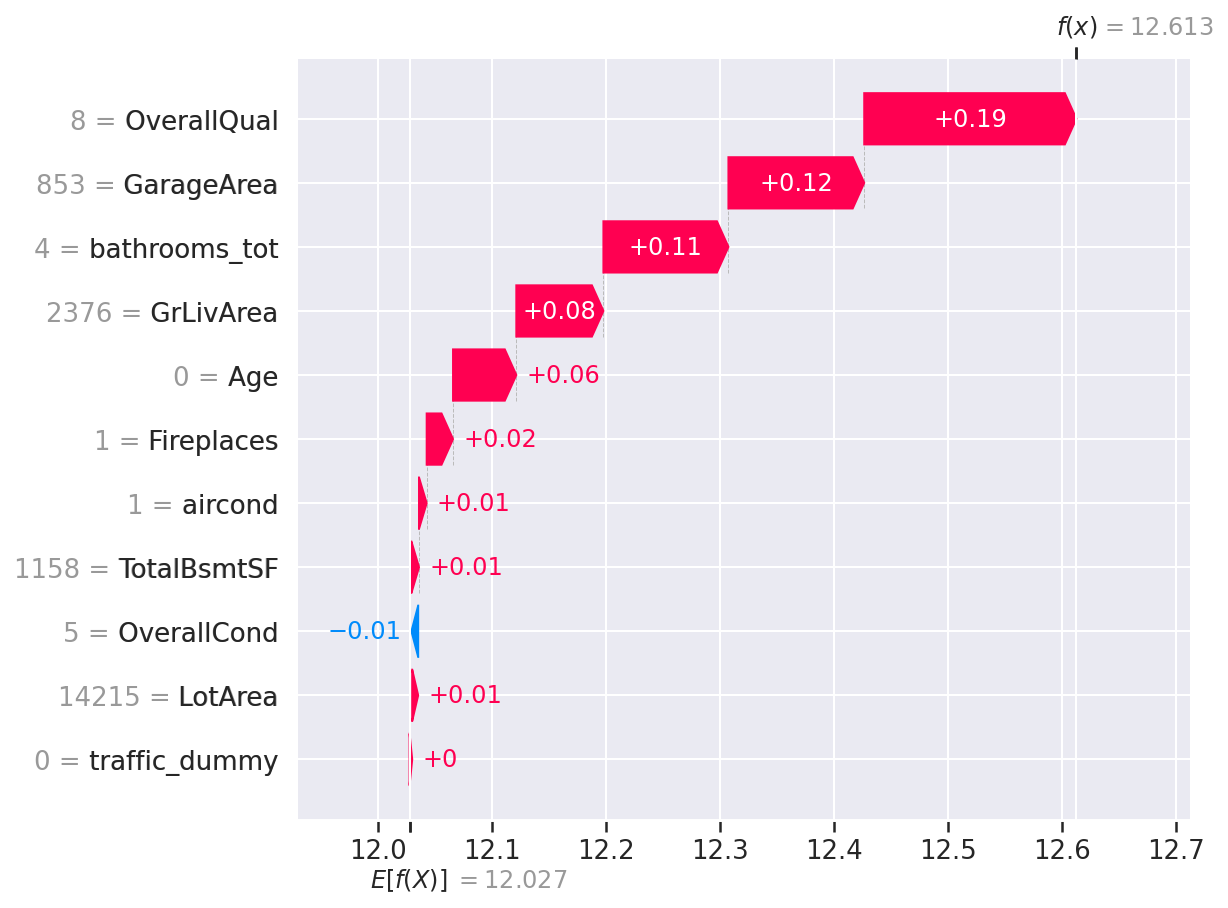

In [372]:
X100 = shap.utils.sample(X, 100)
explainer=shap.Explainer(ols_loglevel, X100)
shap_values=explainer(X)
shap.plots.waterfall(shap_values[18], max_display=15)

The above shown shapley plot shows relative marginal effects of our covariates. It is apparent that Overall Quality is the main feature which influences the house's price.  
Quite surprisingly, our model has been influenced significantly by the Garage Area. This is probably caused by interactions beteen covariates. If I had to continue in this analysis, I would consider removing the garage variable from our covariates' matrix

## Conclusion

Basing upon the EDA findings, I have constructed a regression model which aims at predicting the house prices. I have identified the most significant feature which influence the house price.   
There is naturally a space for further improvements. To get better predictions, I could use standardization of our covariates. I could also use different regression methods, such as Lasso or Ridge regression. However, I may conclude that my model exhibits some predictive abilities which might be used at approximating a house's price.

In [378]:
%%shell
jupyter nbconvert --to html /content/Vondracek_Housing_Prices_Task.ipynb



[NbConvertApp] Converting notebook /content/Vondracek_Housing_Prices_Task.ipynb to html
[NbConvertApp] Writing 2014145 bytes to /content/Vondracek_Housing_Prices_Task.html
